In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image

from generative.inferers import LatentDiffusionInferer
from generative.losses.adversarial_loss import PatchAdversarialLoss
from generative.losses.perceptual import PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from generative.networks.schedulers import DDPMScheduler

print_config()

MONAI version: 1.3.1
Numpy version: 1.26.4
Pytorch version: 2.3.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 96bfda00c6bd290297f5e3514ea227c6be4d08b4
MONAI __file__: /home/<username>/.pyenv/versions/3.9.13/envs/Gen2/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.13.0
Pillow version: 10.3.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.18.0+cu121
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT I

## config

In [4]:
random_seed = 26
image_size = 128

# affect select which type data
# and path of generated result to save
# and path of trained model name
gen_type = "pneumonia_vir"
root_dir = f"./latent_diffusion"
model_path = f"./{root_dir}/model"
os.makedirs(root_dir, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

AUGMENTATION_GAN_root_dir = "./AUGMENTATION_GAN"
CLASSIC_AUG_DIR = os.path.join(AUGMENTATION_GAN_root_dir, 'train_classic', '3000')

normal_src_dir = os.path.join(AUGMENTATION_GAN_root_dir, 'custom_covid_dataset', 'train', 'normal')
normal_500_dir = os.path.join(AUGMENTATION_GAN_root_dir, 'custom_covid_dataset', 'train_classic', '500', 'normal')
normal_1000_dir = os.path.join(AUGMENTATION_GAN_root_dir, 'custom_covid_dataset', 'train_classic', '1000', 'normal')
normal_2000_dir = os.path.join(AUGMENTATION_GAN_root_dir, 'custom_covid_dataset', 'train_classic', '2000', 'normal')

# normal_dir = os.path.join(AUGMENTATION_GAN_root_dir, 'custom_covid_dataset', 'train_classic', '3000', 'normal')
covid_dir = os.path.join(AUGMENTATION_GAN_root_dir, 'custom_covid_dataset', 'train_classic', '3000', 'covid')
pneumonia_bac_dir = os.path.join(AUGMENTATION_GAN_root_dir, 'custom_covid_dataset', 'train_classic', '3000', 'pneumonia_bac')

pneumonia_vir_dir = os.path.join(AUGMENTATION_GAN_root_dir, 'custom_covid_dataset', 'train', 'pneumonia_vir')
pneumonia_500_dir = os.path.join(AUGMENTATION_GAN_root_dir, 'custom_covid_dataset', 'train_classic', '500', 'pneumonia_vir')
pneumonia_1000_dir = os.path.join(AUGMENTATION_GAN_root_dir, 'custom_covid_dataset', 'train_classic', '1000', 'pneumonia_vir')
pneumonia_2000_dir = os.path.join(AUGMENTATION_GAN_root_dir, 'custom_covid_dataset', 'train_classic', '2000', 'pneumonia_vir')

## setup random seed

In [5]:
set_determinism(random_seed)

## prepare train/val dataloader

In [6]:
def get_files(path):
    return [os.path.join(path, i) for i in os.listdir(path) if i.endswith("jpeg") or i.endswith("jpg") or i.endswith("png")]
            
gen_training_img = {
    'normal': get_files(normal_src_dir) +\
            get_files(normal_500_dir) +\
            get_files(normal_1000_dir) +\
            get_files(normal_2000_dir),
    'pneumonia_vir': get_files(pneumonia_vir_dir) +\
        get_files(pneumonia_500_dir) +\
        get_files(pneumonia_1000_dir) +\
        get_files(pneumonia_2000_dir)
}

In [7]:
images = [{'image': i} for i in  gen_training_img[gen_type]]
train_imgs, val_imgs = train_test_split(images)

In [8]:
print(f"training images: {len(train_imgs)}, val images: {len(val_imgs)}")

training images: 1552, val images: 518


In [9]:
image_size

128

In [10]:
from PIL import Image

class ChestDataset(Dataset):
    def __init__(self, imgs, label, transform=None):
        self.transform = transform
        self.imgs = imgs
        self.label = label

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        image = Image.open(self.imgs[idx]).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return {'image': image}

train_transforms = transforms.Compose([
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.Resized(keys="image", spatial_size=(128, 128)),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            # rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[image_size, image_size],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)

val_transforms = transforms.Compose([
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.Resized(keys="image", spatial_size=(128, 128)) 
    ]
)

train_ds = Dataset(data = train_imgs, transform = train_transforms)
val_ds = Dataset(data = val_imgs, transform = val_transforms)
train_loader = DataLoader(
    train_ds, 
    batch_size=32, 
    shuffle=True, 
    num_workers=8, 
    pin_memory=True
)
val_loader = DataLoader(
    val_ds, 
    batch_size=32, 
    shuffle=True, 
    num_workers=8, 
    pin_memory=True
)

## display from train and val dataloader

In [11]:
for img in train_loader:
    print(img['image'].shape)
    break

torch.Size([32, 3, 128, 128])


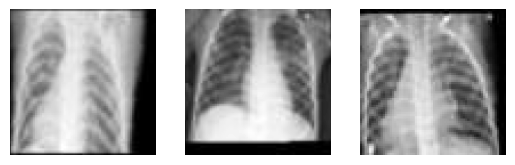

In [12]:
train_demo = first(train_loader)
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(train_demo["image"][image_n, 0, :, :].T, cmap="gray")
    ax[image_n].axis("off")

In [13]:
for img in val_loader:
    print(img['image'].shape)
    break

torch.Size([32, 3, 128, 128])


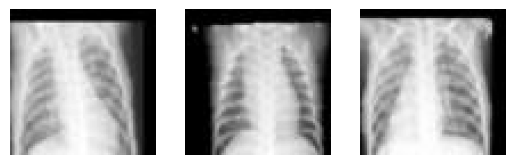

In [14]:
train_demo = first(val_loader)
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(train_demo["image"][image_n, 0, :, :].T, cmap="gray")
    ax[image_n].axis("off")

## training

In [15]:
import torch.nn as nn

device = torch.device("cuda")

autoencoderkl = AutoencoderKL(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_channels=(128, 128, 256),
    latent_channels=3,
    num_res_blocks=2,
    attention_levels=(False, False, False),
    with_encoder_nonlocal_attn=False,
    with_decoder_nonlocal_attn=False,
)
# autoencoderkl = nn.DataParallel(autoencoderkl)
autoencoderkl = autoencoderkl.to(device)

In [33]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)
perceptual_weight = 0.001

/home/chilin/.pyenv/versions/3.9.13/envs/Gen2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/chilin/.pyenv/versions/3.9.13/envs/Gen2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
discriminator = PatchDiscriminator(spatial_dims=2, num_layers_d=3, num_channels=64, in_channels=3, out_channels=3)
discriminator = discriminator.to(device)

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01

In [35]:
optimizer_g = torch.optim.Adam(autoencoderkl.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=5e-4)

# For mixed precision training
scaler_g = torch.cuda.amp.GradScaler()
scaler_d = torch.cuda.amp.GradScaler()

In [36]:
len(train_loader)

49

In [37]:
kl_weight = 1e-6
n_epochs = 300
val_interval = 10
autoencoder_warm_up_n_epochs = 10

epoch_recon_losses = []
epoch_gen_losses = []
epoch_disc_losses = []
val_recon_losses = []
intermediary_images = []
num_example_images = 4

best_val_loss_autoencoder = float('inf')

for epoch in range(n_epochs):
    autoencoderkl.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer_g.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            reconstruction, z_mu, z_sigma = autoencoderkl(images)

            recons_loss = F.l1_loss(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

            if epoch > autoencoder_warm_up_n_epochs:
                logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                loss_g += adv_weight * generator_loss

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

        if epoch > autoencoder_warm_up_n_epochs:
            with autocast(enabled=True):
                optimizer_d.zero_grad(set_to_none=True)

                logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                logits_real = discriminator(images.contiguous().detach())[-1]
                loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

                loss_d = adv_weight * discriminator_loss

            scaler_d.scale(loss_d).backward()
            scaler_d.step(optimizer_d)
            scaler_d.update()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_losses.append(epoch_loss / (step + 1))
    epoch_gen_losses.append(gen_epoch_loss / (step + 1))
    epoch_disc_losses.append(disc_epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        autoencoderkl.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)

                with autocast(enabled=True):
                    reconstruction, z_mu, z_sigma = autoencoderkl(images)
                    # Get the first reconstruction from the first validation batch for visualisation purposes
                    if val_step == 1:
                        intermediary_images.append(reconstruction[:num_example_images, 0])

                    recons_loss = F.l1_loss(images.float(), reconstruction.float())

                val_loss += recons_loss.item()

        val_loss /= val_step
        val_recon_losses.append(val_loss)

        # Save the autoencoder model if it has the best validation loss so far
        if val_loss < best_val_loss_autoencoder:
            best_val_loss_autoencoder = val_loss
            torch.save(autoencoderkl.state_dict(), os.path.join(model_path, f"{gen_type}_best_autoencoderkl.pth"))
            print(f"Saved better autoencoder model at epoch {epoch + 1} with val loss: {val_loss:.4f}")

        
        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")
progress_bar.close()

del discriminator
del perceptual_loss
torch.cuda.empty_cache()

Epoch 9: 100%|███████████████████| 49/49 [00:19<00:00,  2.51it/s, recons_loss=0.0328, gen_loss=0, disc_loss=0]


Saved better autoencoder model at epoch 10 with val loss: 0.0301
epoch 10 val loss: 0.0301


Epoch 11:   0%|                                                                        | 0/49 [00:00<?, ?it/s]/home/chilin/.pyenv/versions/3.9.13/envs/Gen2/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 11:  98%|██████████▊| 48/49 [00:21<00:00,  2.21it/s, recons_loss=0.0345, gen_loss=1.07, disc_loss=0.665]/home/chilin/.pyenv/versions/3.9.13/envs/Gen2/lib/python3.9/site-packages/torch/_tensor.py:1443: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  ret 

Saved better autoencoder model at epoch 20 with val loss: 0.0212
epoch 20 val loss: 0.0212


Epoch 29: 100%|███████████| 49/49 [00:22<00:00,  2.20it/s, recons_loss=0.0221, gen_loss=0.51, disc_loss=0.206]


epoch 30 val loss: 0.0240


Epoch 39: 100%|██████████| 49/49 [00:22<00:00,  2.21it/s, recons_loss=0.0288, gen_loss=0.508, disc_loss=0.322]


epoch 40 val loss: 0.0238


Epoch 49: 100%|██████████| 49/49 [00:22<00:00,  2.18it/s, recons_loss=0.0236, gen_loss=0.275, disc_loss=0.254]


Saved better autoencoder model at epoch 50 with val loss: 0.0164
epoch 50 val loss: 0.0164


Epoch 59: 100%|██████████| 49/49 [00:22<00:00,  2.16it/s, recons_loss=0.0204, gen_loss=0.418, disc_loss=0.318]


epoch 60 val loss: 0.0190


Epoch 69: 100%|██████████| 49/49 [00:22<00:00,  2.16it/s, recons_loss=0.0187, gen_loss=0.317, disc_loss=0.249]


Saved better autoencoder model at epoch 70 with val loss: 0.0155
epoch 70 val loss: 0.0155


Epoch 79: 100%|██████████| 49/49 [00:22<00:00,  2.17it/s, recons_loss=0.0201, gen_loss=0.495, disc_loss=0.241]


epoch 80 val loss: 0.0178


Epoch 89: 100%|███████████| 49/49 [00:22<00:00,  2.17it/s, recons_loss=0.0175, gen_loss=0.282, disc_loss=0.27]


epoch 90 val loss: 0.0170


Epoch 99: 100%|██████████| 49/49 [00:22<00:00,  2.17it/s, recons_loss=0.0187, gen_loss=0.421, disc_loss=0.204]


epoch 100 val loss: 0.0181


Epoch 109: 100%|█████████| 49/49 [00:22<00:00,  2.17it/s, recons_loss=0.0192, gen_loss=0.493, disc_loss=0.192]


Saved better autoencoder model at epoch 110 with val loss: 0.0152
epoch 110 val loss: 0.0152


Epoch 119: 100%|███████████| 49/49 [00:22<00:00,  2.15it/s, recons_loss=0.016, gen_loss=0.259, disc_loss=0.26]


Saved better autoencoder model at epoch 120 with val loss: 0.0131
epoch 120 val loss: 0.0131


Epoch 129: 100%|█████████| 49/49 [00:22<00:00,  2.15it/s, recons_loss=0.0169, gen_loss=0.259, disc_loss=0.251]


Saved better autoencoder model at epoch 130 with val loss: 0.0119
epoch 130 val loss: 0.0119


Epoch 139: 100%|█████████| 49/49 [00:22<00:00,  2.17it/s, recons_loss=0.0137, gen_loss=0.262, disc_loss=0.251]


epoch 140 val loss: 0.0130


Epoch 149: 100%|█████████| 49/49 [00:22<00:00,  2.18it/s, recons_loss=0.0141, gen_loss=0.275, disc_loss=0.255]


Saved better autoencoder model at epoch 150 with val loss: 0.0101
epoch 150 val loss: 0.0101


Epoch 159: 100%|█████████| 49/49 [00:22<00:00,  2.18it/s, recons_loss=0.0116, gen_loss=0.281, disc_loss=0.251]


Saved better autoencoder model at epoch 160 with val loss: 0.0094
epoch 160 val loss: 0.0094


Epoch 169: 100%|█████████| 49/49 [00:22<00:00,  2.19it/s, recons_loss=0.0113, gen_loss=0.286, disc_loss=0.257]


epoch 170 val loss: 0.0101


Epoch 179: 100%|█████████| 49/49 [00:22<00:00,  2.18it/s, recons_loss=0.0117, gen_loss=0.292, disc_loss=0.234]


epoch 180 val loss: 0.0200


Epoch 189: 100%|█████████| 49/49 [00:23<00:00,  2.09it/s, recons_loss=0.0103, gen_loss=0.269, disc_loss=0.246]


epoch 190 val loss: 0.0110


Epoch 199: 100%|████████| 49/49 [00:24<00:00,  2.00it/s, recons_loss=0.00949, gen_loss=0.273, disc_loss=0.245]


epoch 200 val loss: 0.0096


Epoch 209: 100%|█████████| 49/49 [00:23<00:00,  2.06it/s, recons_loss=0.0117, gen_loss=0.275, disc_loss=0.261]


epoch 210 val loss: 0.0095


Epoch 219: 100%|█████████| 49/49 [00:23<00:00,  2.07it/s, recons_loss=0.0112, gen_loss=0.275, disc_loss=0.243]


epoch 220 val loss: 0.0182


Epoch 229: 100%|█████████| 49/49 [00:23<00:00,  2.05it/s, recons_loss=0.00996, gen_loss=0.28, disc_loss=0.249]


epoch 230 val loss: 0.0118


Epoch 239: 100%|████████| 49/49 [00:24<00:00,  2.03it/s, recons_loss=0.00964, gen_loss=0.323, disc_loss=0.227]


Saved better autoencoder model at epoch 240 with val loss: 0.0082
epoch 240 val loss: 0.0082


Epoch 249: 100%|████████| 49/49 [00:24<00:00,  2.01it/s, recons_loss=0.00991, gen_loss=0.298, disc_loss=0.239]


epoch 250 val loss: 0.0089


Epoch 259: 100%|█████████| 49/49 [00:24<00:00,  1.97it/s, recons_loss=0.0105, gen_loss=0.307, disc_loss=0.231]


epoch 260 val loss: 0.0115


Epoch 269: 100%|█████████| 49/49 [00:24<00:00,  1.99it/s, recons_loss=0.00992, gen_loss=0.31, disc_loss=0.235]


Saved better autoencoder model at epoch 270 with val loss: 0.0080
epoch 270 val loss: 0.0080


Epoch 279: 100%|█████████| 49/49 [00:24<00:00,  2.03it/s, recons_loss=0.0101, gen_loss=0.321, disc_loss=0.235]


epoch 280 val loss: 0.0085


Epoch 289: 100%|█████████| 49/49 [00:23<00:00,  2.06it/s, recons_loss=0.0124, gen_loss=0.303, disc_loss=0.236]


epoch 290 val loss: 0.0094


Epoch 299: 100%|████████| 49/49 [00:24<00:00,  2.03it/s, recons_loss=0.00988, gen_loss=0.312, disc_loss=0.236]


epoch 300 val loss: 0.0120


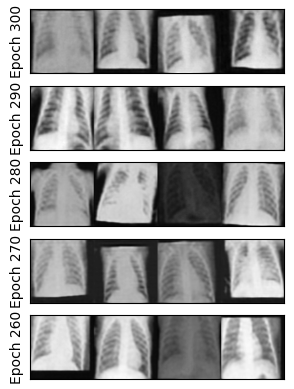

In [38]:
# Plot last 5 evaluations
val_samples = np.linspace(n_epochs, val_interval, int(n_epochs / val_interval))
fig, ax = plt.subplots(nrows=5, ncols=1, sharey=True)
for image_n in range(5):
    reconstructions = torch.reshape(intermediary_images[image_n], (image_size * num_example_images, image_size)).T
    ax[image_n].imshow(reconstructions.cpu(), cmap="gray")
    ax[image_n].set_xticks([])
    ax[image_n].set_yticks([])
    ax[image_n].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

In [16]:
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_res_blocks=2,
    num_channels=(128, 256, 512),
    attention_levels=(False, True, True),
    num_head_channels=(0, 256, 512),
)

scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)

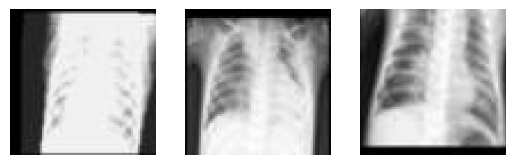

In [17]:
check_data = first(train_loader)
fig, ax = plt.subplots(nrows=1, ncols=3)
for image_n in range(3):
    ax[image_n].imshow(check_data["image"][image_n, 0, :, :].T, cmap="gray")
    ax[image_n].axis("off")

In [18]:
autoencoderkl.load_state_dict(torch.load(os.path.join(model_path, f"{gen_type}_best_autoencoderkl.pth")))
autoencoderkl.eval()

AutoencoderKL(
  (encoder): Encoder(
    (blocks): ModuleList(
      (0): Convolution(
        (conv): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1-2): 2 x ResBlock(
        (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
        (conv1): Convolution(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
        (conv2): Convolution(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (nin_shortcut): Identity()
      )
      (3): Downsample(
        (conv): Convolution(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (4-5): 2 x ResBlock(
        (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
        (conv1): Convolution(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (norm2): GroupNorm(3

In [19]:
with torch.no_grad():
    with autocast(enabled=True):
        # z = autoencoderkl.encode_stage_2_inputs(check_data["image"].to(device))
        z = autoencoderkl.encode_stage_2_inputs(check_data["image"].to(device))

print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)

Scaling factor set to 0.9373854398727417


In [20]:
inferer = LatentDiffusionInferer(scheduler, scale_factor=scale_factor)

Epoch 19: 100%|███████████| 49/49 [00:12<00:00,  3.89it/s, loss=0.167]


Epoch 19 val loss: 0.1664
Saved improved model with validation loss 0.1664


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.64it/s]


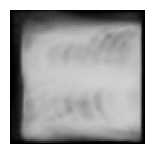

Epoch 39: 100%|███████████| 49/49 [00:12<00:00,  3.87it/s, loss=0.158]


Epoch 39 val loss: 0.1913


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.44it/s]


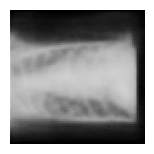

Epoch 79: 100%|███████████| 49/49 [00:13<00:00,  3.77it/s, loss=0.153]


Epoch 79 val loss: 0.1508
Saved improved model with validation loss 0.1508


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.93it/s]


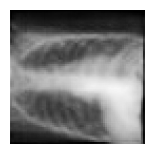

Epoch 90:  22%|██▍        | 11/49 [00:03<00:09,  3.83it/s, loss=0.146]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 239: 100%|██████████| 49/49 [00:13<00:00,  3.69it/s, loss=0.161]


Epoch 239 val loss: 0.1642


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.80it/s]


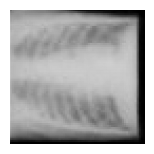

Epoch 259: 100%|██████████| 49/49 [00:13<00:00,  3.71it/s, loss=0.144]


Epoch 259 val loss: 0.1640


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.24it/s]


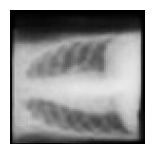

Epoch 279: 100%|███████████| 49/49 [00:13<00:00,  3.70it/s, loss=0.15]


Epoch 279 val loss: 0.1525


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.27it/s]


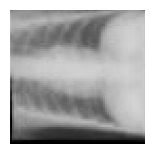

Epoch 299: 100%|██████████| 49/49 [00:13<00:00,  3.73it/s, loss=0.151]


Epoch 299 val loss: 0.1452


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 81.29it/s]


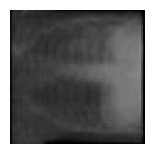

In [21]:
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)

unet = unet.to(device)
n_epochs = 300
val_interval = 20
epoch_losses = []
val_losses = []
scaler = GradScaler()

best_val_loss = float('inf')  

for epoch in range(n_epochs):
    unet.train()
    autoencoderkl.eval()
    # autoencoderkl.eval()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=True):
            # z_mu, z_sigma = autoencoderkl.module.encode(images)
            z_mu, z_sigma = autoencoderkl.encode(images)
            # z = autoencoderkl.module.sampling(z_mu, z_sigma)
            z = autoencoderkl.sampling(z_mu, z_sigma)
            noise = torch.randn_like(z).to(device)
            timesteps = torch.randint(0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device).long()
            noise_pred = inferer(
                inputs=images, diffusion_model=unet, noise=noise, timesteps=timesteps, autoencoder_model=autoencoderkl
            )
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_losses.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        unet.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)

                with autocast(enabled=True):
                    # z_mu, z_sigma = autoencoderkl.module.encode(images)
                    z_mu, z_sigma = autoencoderkl.encode(images)
                    # z = autoencoderkl.module.sampling(z_mu, z_sigma)
                    z = autoencoderkl.sampling(z_mu, z_sigma)

                    noise = torch.randn_like(z).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device
                    ).long()
                    noise_pred = inferer(
                        inputs=images,
                        diffusion_model=unet,
                        noise=noise,
                        timesteps=timesteps,
                        autoencoder_model=autoencoderkl,
                    )

                    loss = F.mse_loss(noise_pred.float(), noise.float())

                val_loss += loss.item()
        val_loss /= val_step
        val_losses.append(val_loss)
        print(f"Epoch {epoch} val loss: {val_loss:.4f}")

        # Save the model if it has the best validation loss so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(unet.state_dict(), os.path.join(model_path, f"{gen_type}_best_unet_model.pth"))

            print(f"Saved improved model with validation loss {best_val_loss:.4f}")
        
        # Sampling image during training
        z = torch.randn((1, 3, 32, 32))
        z = z.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(enabled=True):
            decoded = inferer.sample(
                input_noise=z, diffusion_model=unet, scheduler=scheduler, autoencoder_model=autoencoderkl
            )

        plt.figure(figsize=(2, 2))
        plt.style.use("default")
        plt.imshow(decoded[0, 0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()
progress_bar.close()

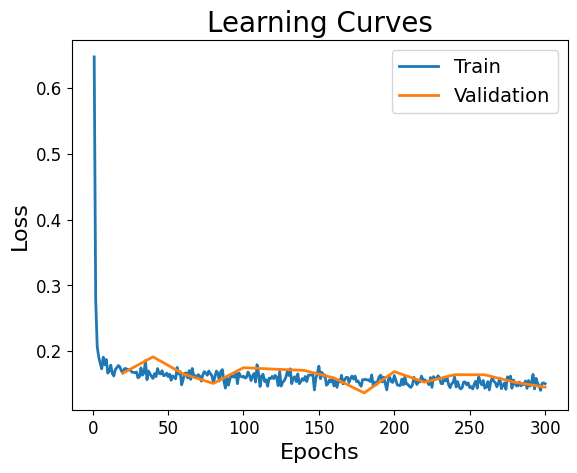

In [22]:
plt.figure()
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_losses, linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)), val_losses, linewidth=2.0, label="Validation"
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})

In [25]:
unet.eval()
scheduler.set_timesteps(num_inference_steps=1000)
noise = torch.randn((1, 3, 32, 32))
noise = noise.to(device)

with torch.no_grad():
    image, intermediates = inferer.sample(
        input_noise=noise,
        diffusion_model=unet,
        scheduler=scheduler,
        save_intermediates=True,
        intermediate_steps=100,
        autoencoder_model=autoencoderkl,
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 101.01it/s]


(-0.5, 1279.5, 127.5, -0.5)

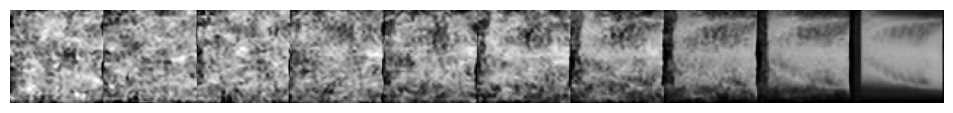

In [26]:
# Decode latent representation of the intermediary images
decoded_images = []
for image in intermediates:
    with torch.no_grad():
        decoded_images.append(image)
plt.figure(figsize=(10, 12))
chain = torch.cat(decoded_images, dim=-1)
plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")

In [27]:
image.shape

torch.Size([1, 3, 128, 128])

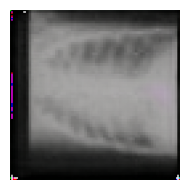

In [28]:
import torchvision.transforms.functional as F

for i in image:
    plt.figure(figsize=(2, 2))
    # chain = torch.cat(image, dim=-1)
    plt.style.use("default")
    plt.imshow(F.to_pil_image(i.cpu()), vmin=0, vmax=1, cmap="gray")
    plt.tight_layout()
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    plt.close()